In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import networkx as nx
import tqdm 
plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (20,15)

In [2]:
books = []
for i in range(5):
    df = pd.read_csv('data/asoiaf-book{}-edges.csv'.format(i+1))
    books.append(df)

In [3]:
all_books = pd.concat(books)

In [4]:
all_books.head()

Source              Target        Type  weight  \
0                   Addam-Marbrand     Jaime-Lannister  Undirected       3   
1                   Addam-Marbrand     Tywin-Lannister  Undirected       6   
2                Aegon-I-Targaryen  Daenerys-Targaryen  Undirected       5   
3                Aegon-I-Targaryen        Eddard-Stark  Undirected       4   
4  Aemon-Targaryen-(Maester-Aemon)      Alliser-Thorne  Undirected       4   

   book  
0   1.0  
1   1.0  
2   1.0  
3   1.0  
4   1.0

In [5]:
edges = all_books.groupby(['Source','Target']).agg({'weight' : 'sum'}).reset_index()

In [6]:
edges.sort_values('weight',ascending=False).head()

Source            Target  weight
1334       Eddard-Stark  Robert-Baratheon     334
2031           Jon-Snow     Samwell-Tarly     228
1965  Joffrey-Baratheon       Sansa-Stark     222
1972  Joffrey-Baratheon  Tyrion-Lannister     219
640          Bran-Stark             Hodor     209

In [7]:
G = nx.from_pandas_edgelist(edges,source='Source',target='Target',edge_attr='weight')

In [8]:
print(nx.info(G))

Graph with 796 nodes and 2823 edges


In [9]:
weighted_degrees = dict(nx.degree(G,weight='weight'))
max_degree = max(weighted_degrees.values())

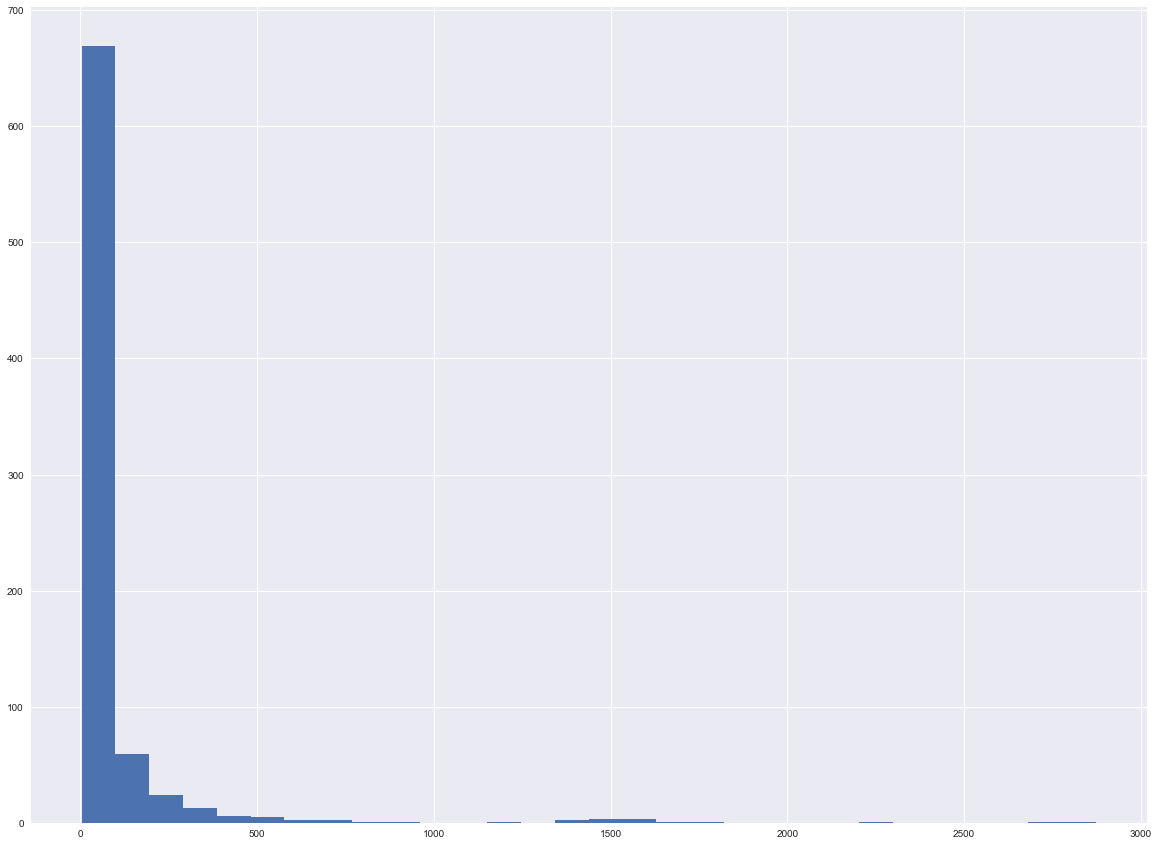

In [10]:
plt.hist(weighted_degrees.values(),bins=30)
plt.show()

In [11]:
subG = G.subgraph([n for n in weighted_degrees if weighted_degrees[n] > 200])

In [12]:
print(nx.info(subG))

Graph with 63 nodes and 496 edges


In [13]:
pos = nx.spring_layout(subG,weight='weight',iterations = 20,k=4)

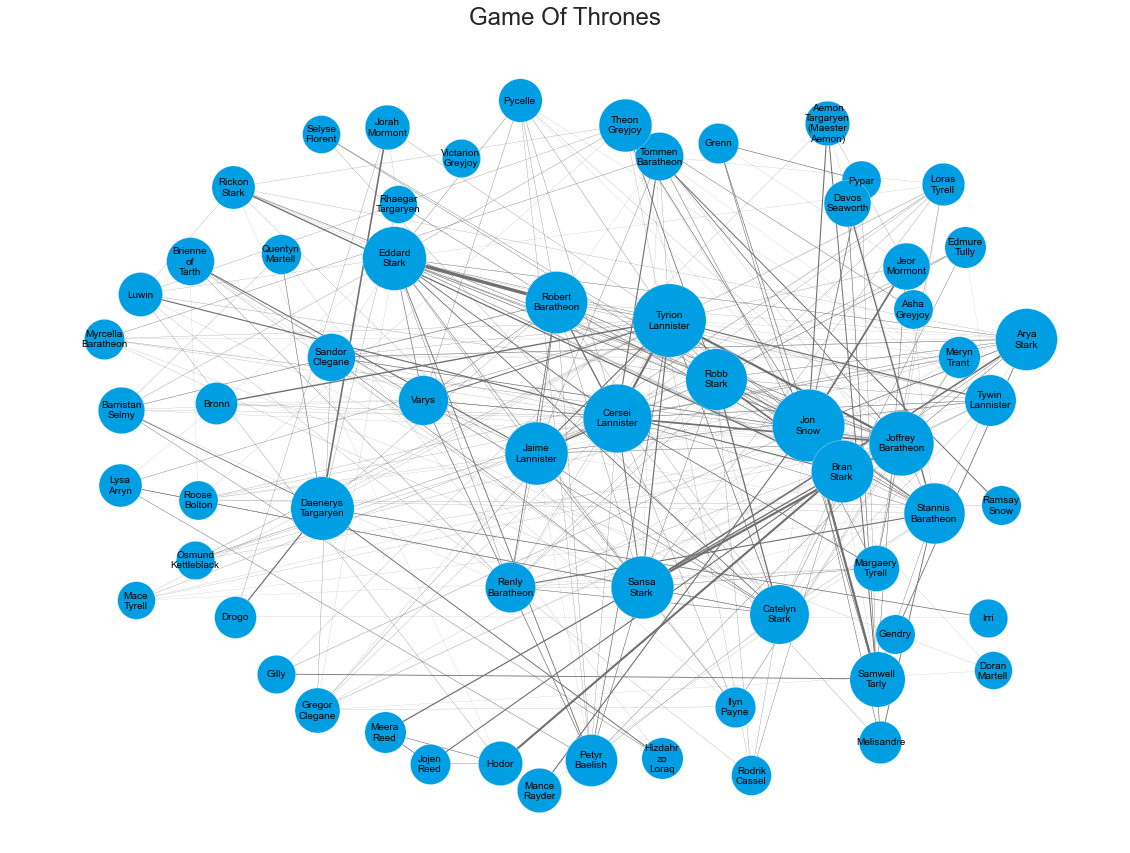

In [14]:
plt.axis('off')
plt.title('Game Of Thrones',fontsize = 24)
for node in subG.nodes():
    size = 100 * weighted_degrees[node] ** 0.5
    ns = nx.draw_networkx_nodes(subG,pos,nodelist=[node],node_size=size,node_color="#009FE3")
    ns.set_edgecolor("#F2F5FA")

nx.draw_networkx_labels(subG,pos,{n : n.replace('-','\n') for n in subG.nodes() if weighted_degrees[n] > 100},font_size=10)
for e in subG.edges(data = True):
    if e[2]['weight'] > 10:
        nx.draw_networkx_edges(subG,pos,[e],width=e[2]['weight']/100,edge_color="#707070")

In [15]:
infection_times = {}

In [16]:
def independent_cascade(G,t,infection_times):
    max_weight = max([e[2]['weight'] for e in G.edges(data=True)])
    current_infections = [n for n in infection_times if infection_times[n] == t]
    
    for n in current_infections:
        for v in G.neighbors(n):
            if v not in infection_times:
                if G.get_edge_data(n,v)['weight'] >= np.random.random() * max_weight:
                    infection_times[v] = t + 1
    
    return infection_times

In [17]:
def plot_G(G,pos,infection_times,t):
    current_infectious = [n for n in infection_times if infection_times[n] == t]
    plt.figure()
    plt.axis('off')
    plt.title('Game of Thrones Network, t = {}'.format(t),fontsize = 24)
    
    for node in G.nodes():
        size = 100 * weighted_degrees[node] ** 0.5
        color = "#000"
        if node in current_infectious:
            color = "#FEBA02"
        elif infection_times.get(node,9999999) < t:
            color = "#f2f6fa"
        else:
            color = "#009fe3"
        ns = nx.draw_networkx_nodes(G,pos,nodelist=[node],node_size=size,node_color=color)
        ns.set_edgecolor("#F2F6FA")
    
    nx.draw_networkx_labels(G,pos,{n : n.replace('-','\n') for n in G.nodes() if weighted_degrees[n] > 100},font_size=10)

    for e in G.edges(data=True):
        if e[2]['weight'] > 10:
            nx.draw_networkx_edges(G,pos,[e],width=e[2]['weight']/100,edge_color="#707070")

In [18]:
infection_times = {'Bran-Stark':-1,'Samwell-Tarly':-1,'Jon-Snow':0}

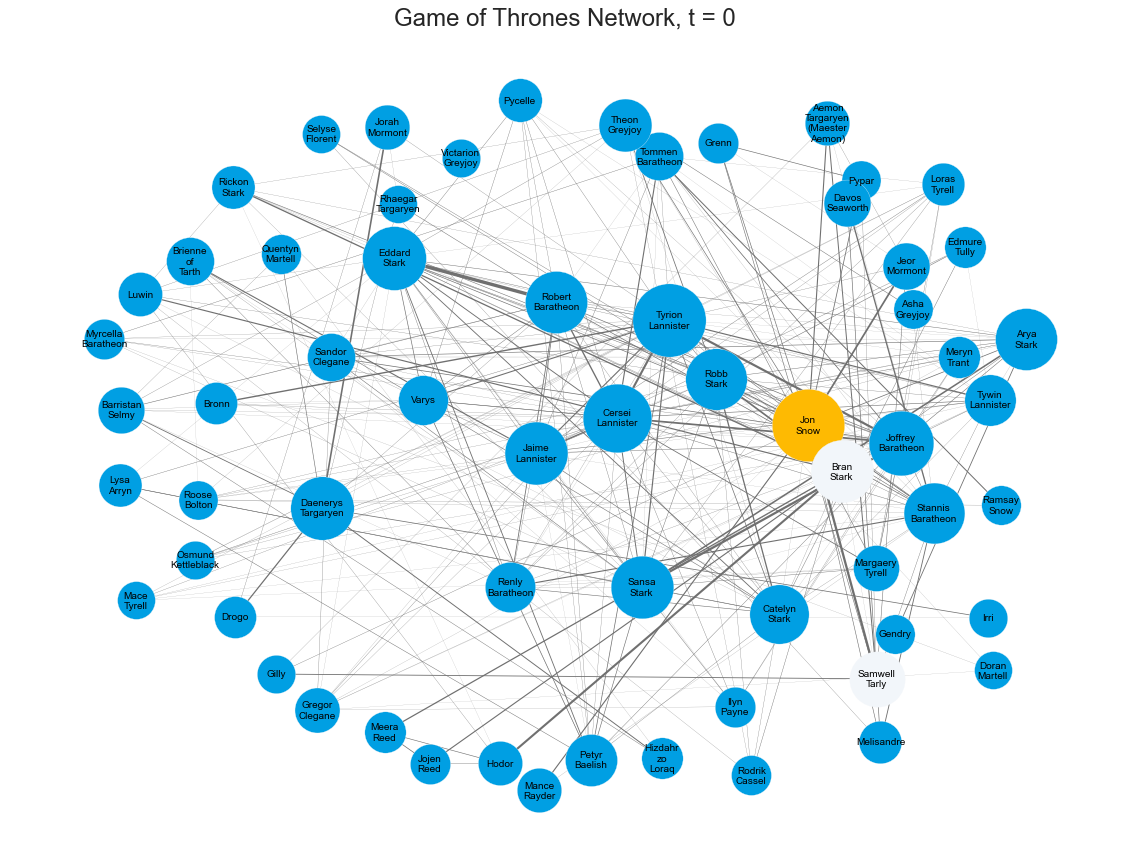

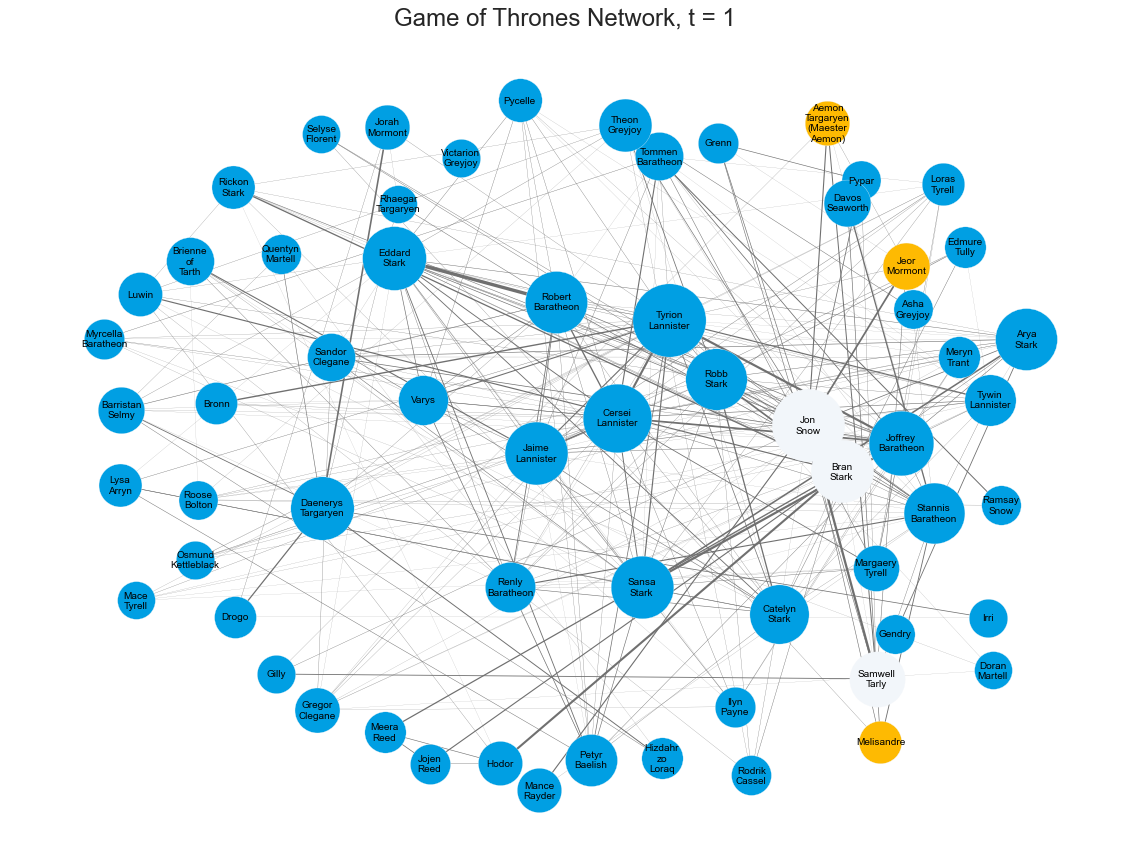

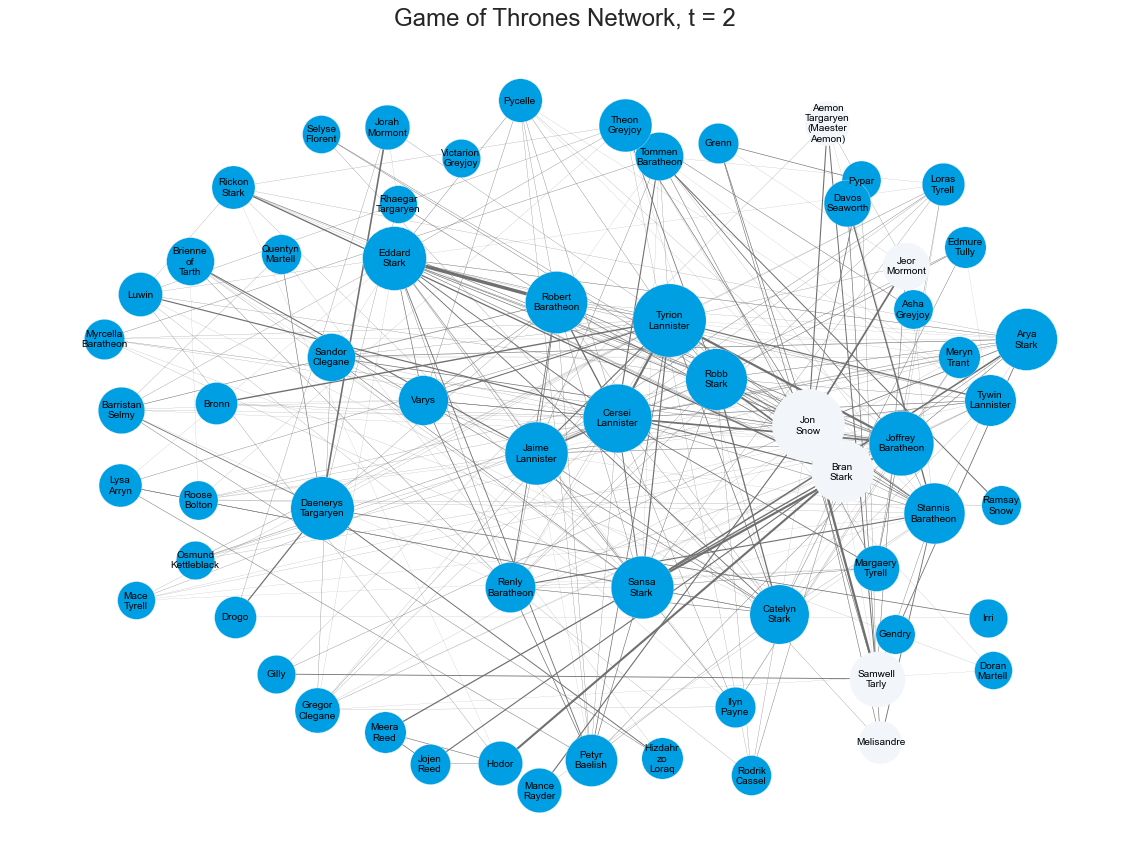

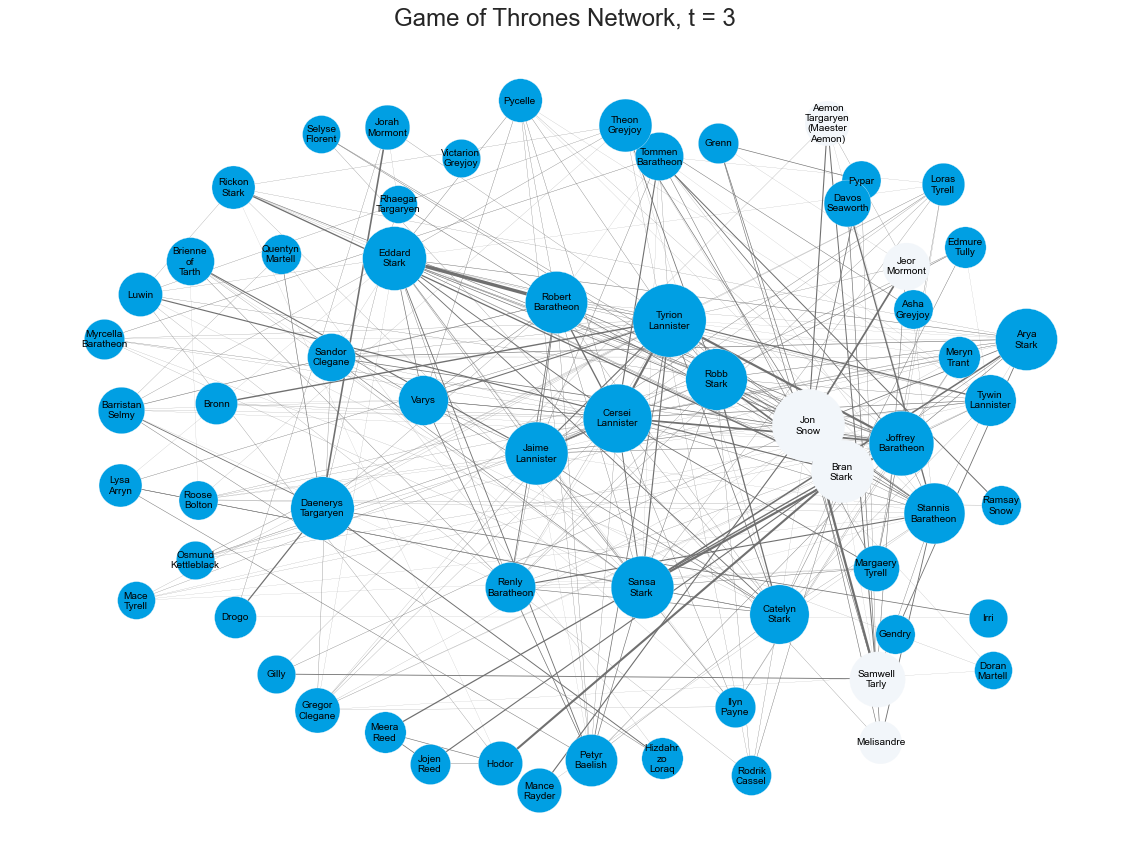

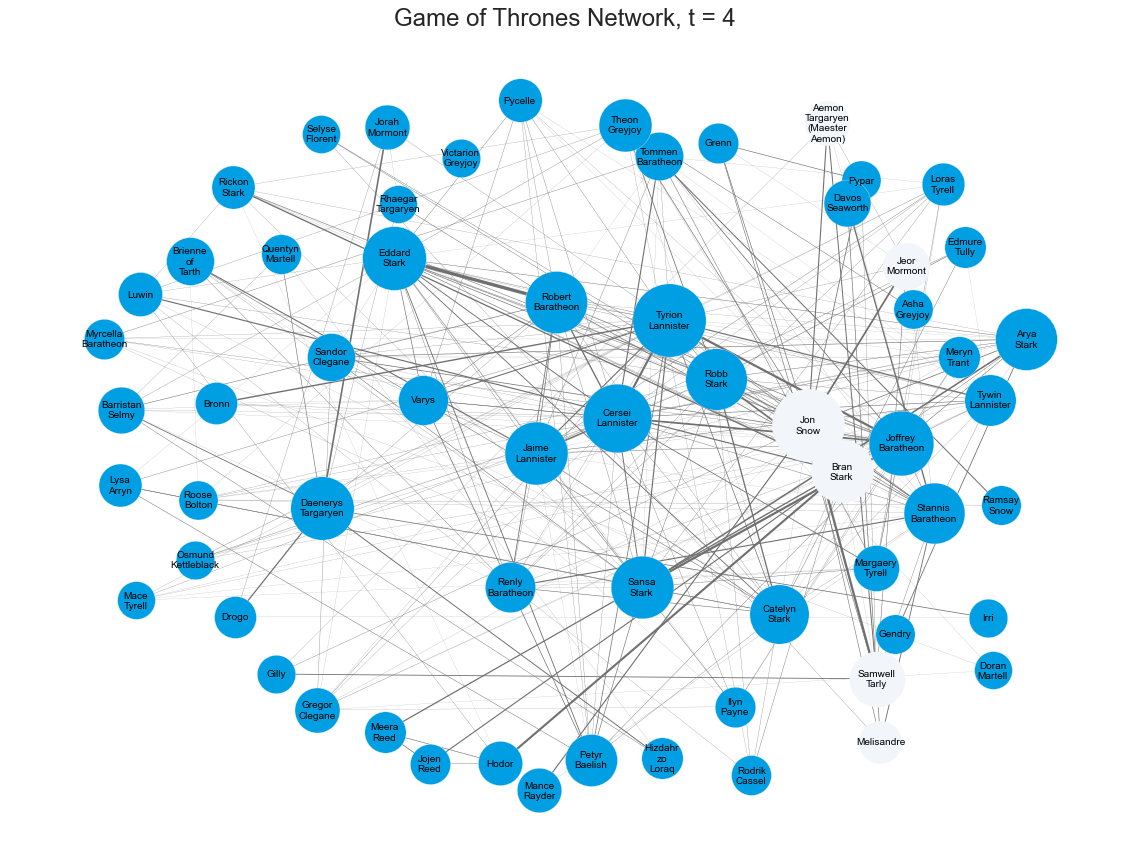

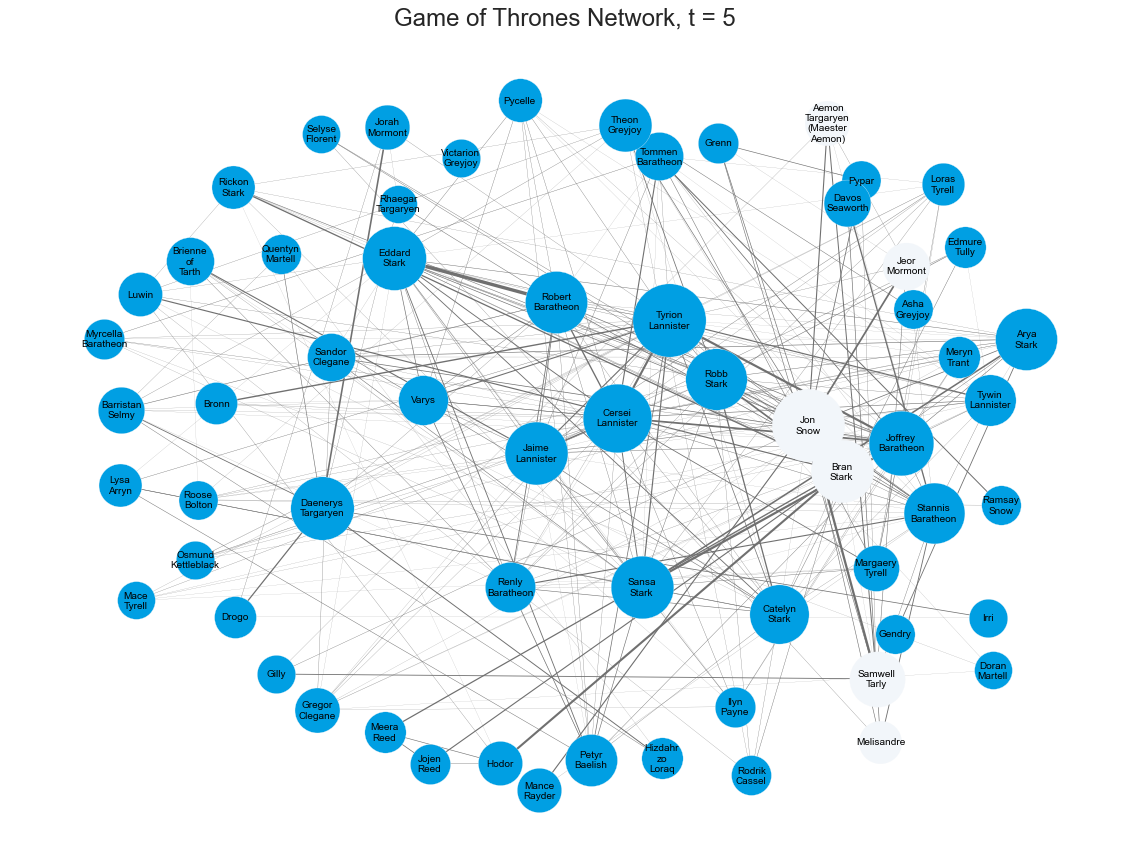

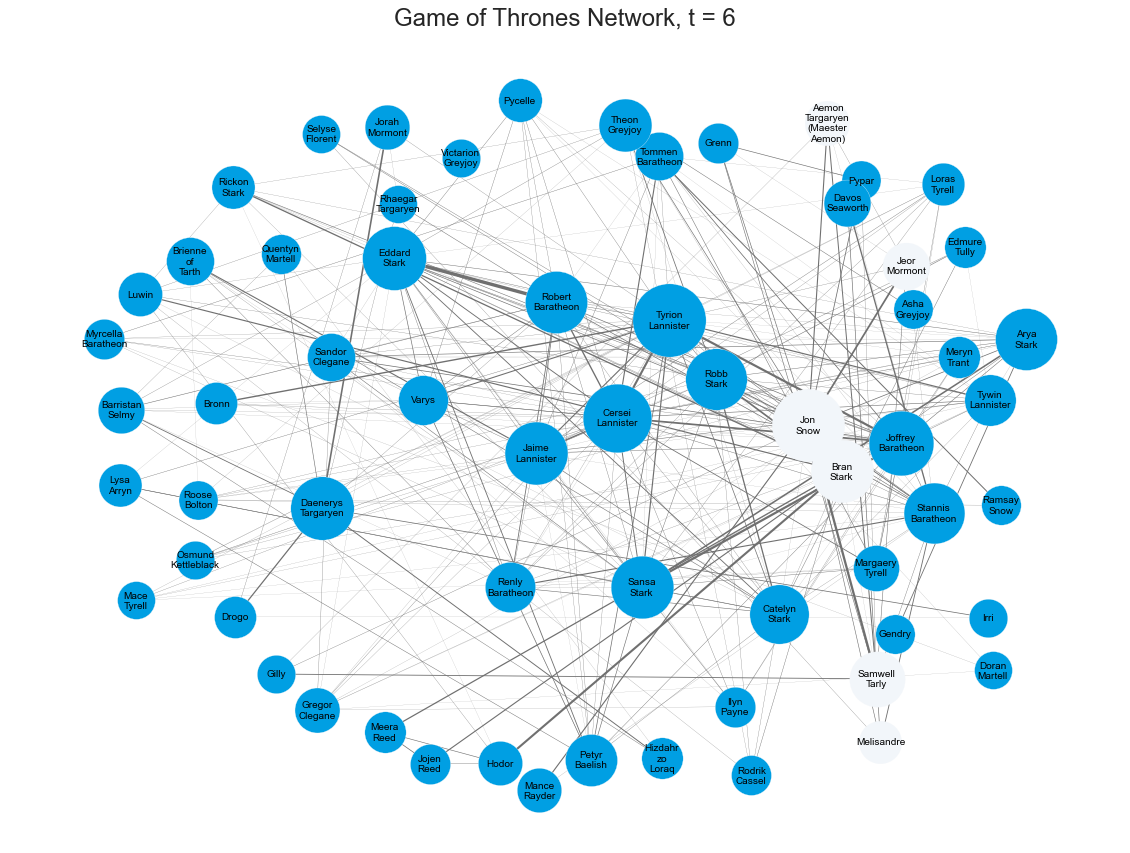

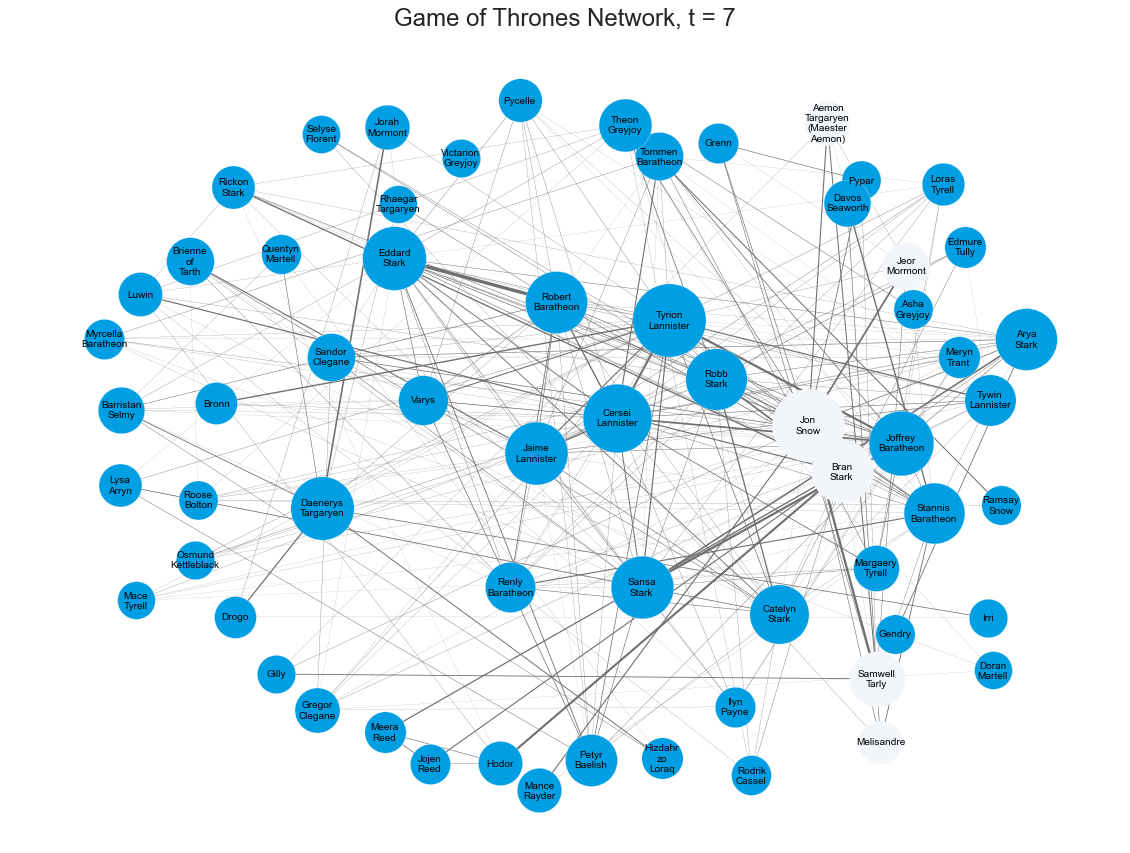

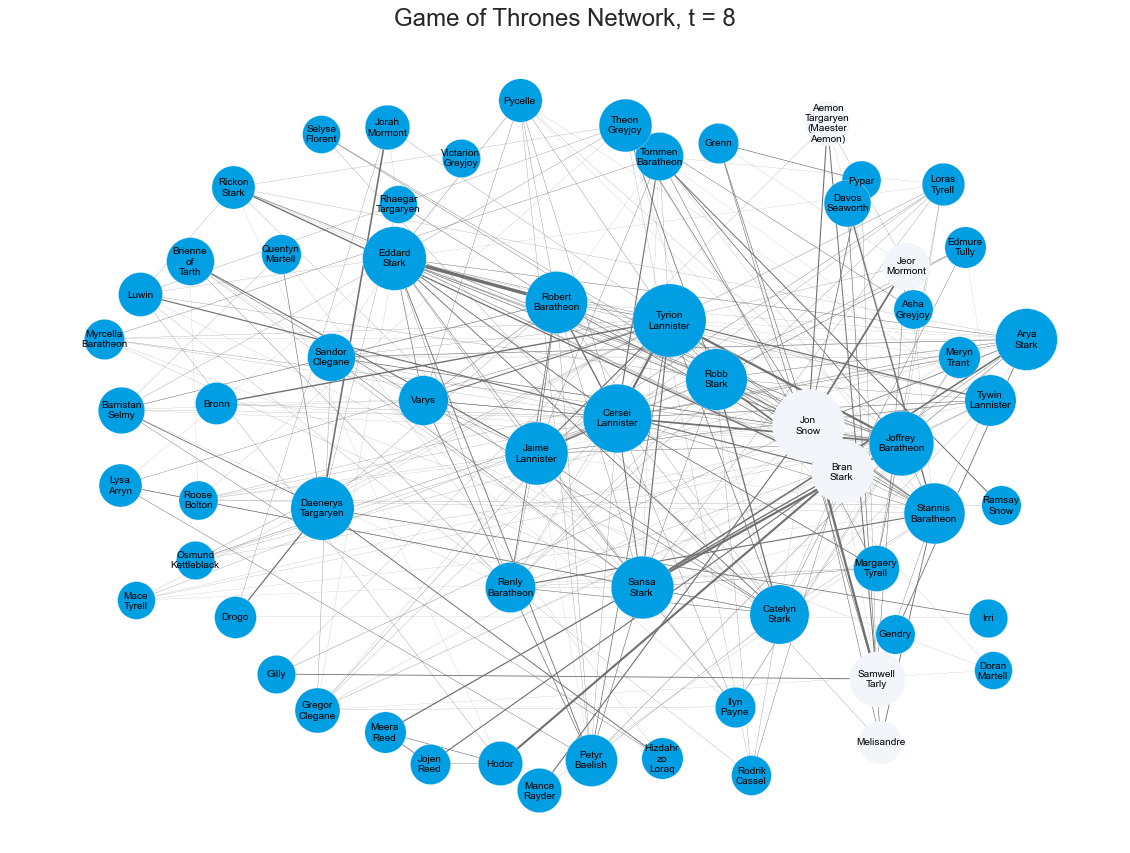

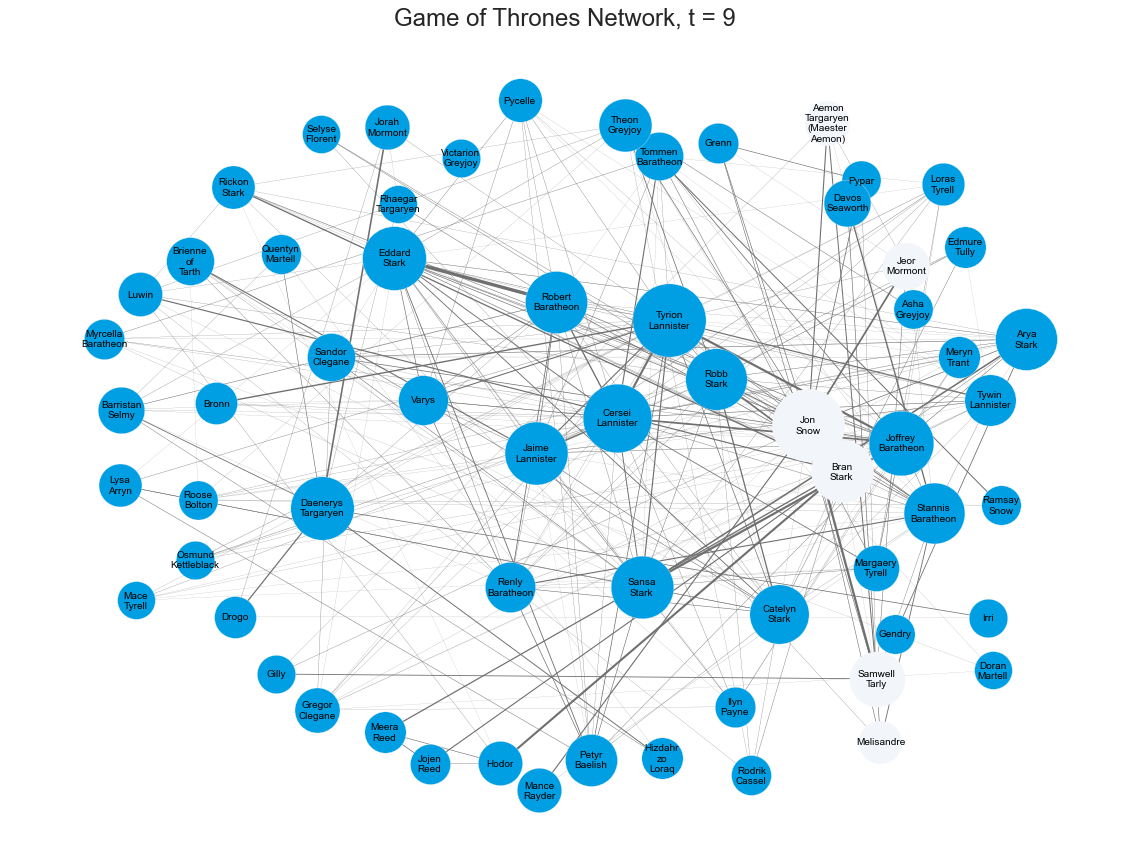

In [19]:
for t in range(10):
    plot_G(subG,pos,infection_times,t)
    infection_times = independent_cascade(subG,t,infection_times)

In [20]:
df = pd.DataFrame.from_dict(dict(nx.degree(subG)),orient='index').sort_values(0,ascending=False)
df.columns = ['Degree']
df['Weighted Degree'] = pd.DataFrame.from_dict(dict(nx.degree(subG,weight='weight')),orient='index')
df['PageRank'] = pd.DataFrame.from_dict(dict(nx.pagerank(subG,weight='weight')),orient='index')
df['Betweenness'] = pd.DataFrame.from_dict(dict(nx.betweenness_centrality(subG,weight='weight')),orient='index')

In [21]:
df.head()

Degree  Weighted Degree  PageRank  Betweenness
Tyrion-Lannister       40             1842  0.052707     0.036445
Robert-Baratheon       37             1271  0.037013     0.223912
Joffrey-Baratheon      35             1518  0.042825     0.033051
Eddard-Stark           34             1330  0.037788     0.024061
Cersei-Lannister       34             1627  0.046175     0.004671

In [22]:
print(nx.info(subG))

Graph with 63 nodes and 496 edges


In [23]:
columns = df.columns

max_budget = len(subG.nodes())
trials = 50 
all_results = []

for budget in tqdm.tqdm_notebook(range(max_budget)):
    results = {'budget' : budget}
    for column in columns:
        infections = []
        for i in range(trials):
            infected = 0
            t = 0
            infection_times = { n : 0 for n in df.sort_values(column,ascending=False).index[:budget]}
            while len(infection_times) > infected:
                infected = len(infection_times)
                infection_times = independent_cascade(subG,t,infection_times)
                t += 1
                
            infections.append(infected)
        results[column] = np.round(np.mean(infections)/len(subG.nodes()),2)
    all_results.append(results)

C:\Users\admin\AppData\Local\Temp/ipykernel_6680/2925467379.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for budget in tqdm.tqdm_notebook(range(max_budget)):


  0%|          | 0/63 [00:00<?, ?it/s]

In [24]:
df = pd.concat([pd.DataFrame.from_dict(res,orient='index').T for res in all_results]).set_index('budget')

In [25]:
df.index = df.index/len(subG.nodes())

In [26]:
df.head()

Degree  Weighted Degree  PageRank  Betweenness
budget                                                  
0.000000    0.00             0.00      0.00         0.00
0.015873    0.49             0.51      0.50         0.51
0.031746    0.53             0.51      0.51         0.50
0.047619    0.51             0.51      0.52         0.52
0.063492    0.52             0.53      0.53         0.55

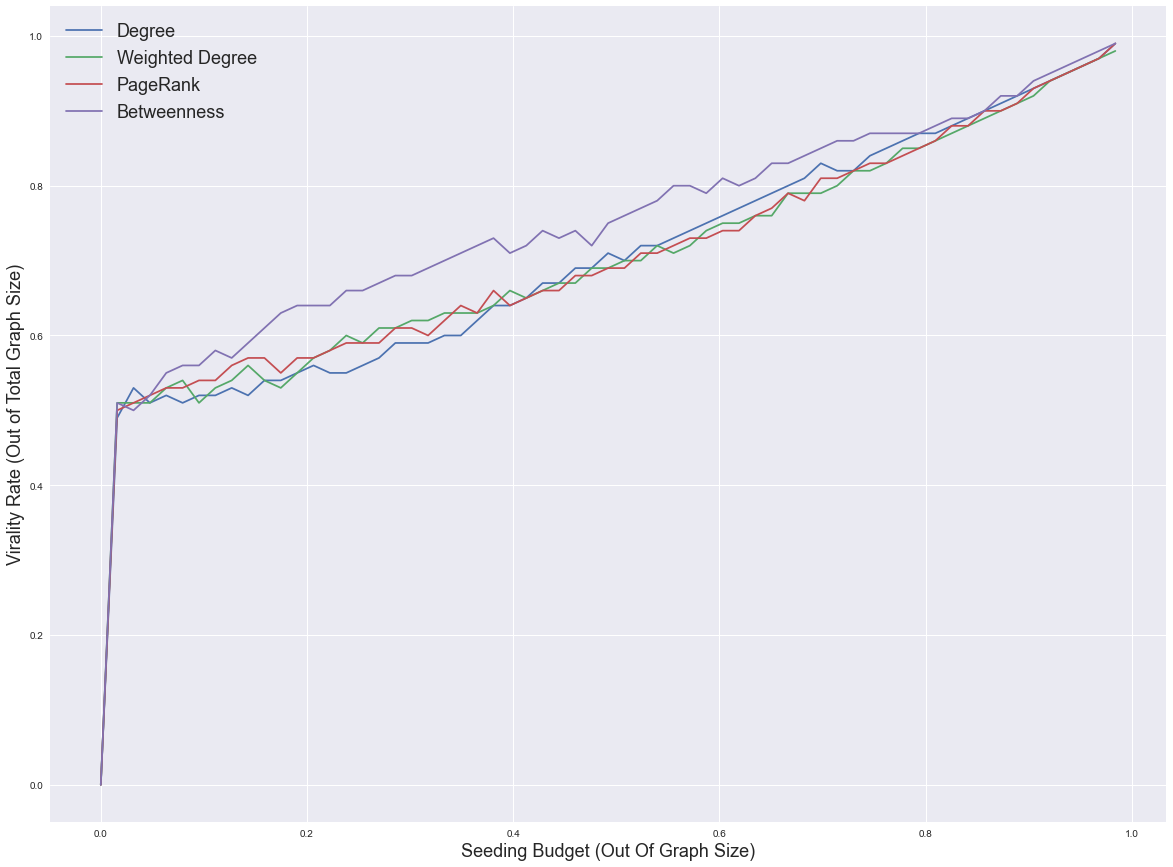

In [27]:
df.plot()
plt.legend(fontsize = 18)
plt.ylabel('Virality Rate (Out of Total Graph Size)',fontsize = 18)
plt.xlabel('Seeding Budget (Out Of Graph Size)',fontsize = 18)
plt.show()

In [28]:
from itertools import product

budget = 2
seed_sets = list(product(*[subG.nodes()] * budget))
print("Seeding Options",len(seed_sets))

Seeding Options 3969


In [ ]:
trials = 20

all_res = []
res = {'budget' : budget}

for seed in tqdm.tqdm_notebook(seed_sets[:]):
    infections = []
    for i in range(trials):
        infected = 0
        t = 0
        infection_times = {n : 0 for n in seed}
        
        while len(infection_times) > infected:
            infected = len(infection_times)
            infection_times = independent_cascade(subG,t,infection_times)
            t += 1
        infections.append(infected)
    res[seed] = np.round(np.mean(infections)/len(subG.nodes()),2)
all_res.append(res)

C:\Users\admin\AppData\Local\Temp/ipykernel_6680/1828340204.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for seed in tqdm.tqdm_notebook(seed_sets[:]):


  0%|          | 0/3969 [00:00<?, ?it/s]

In [ ]:
sorted(res.items(), key = lambda x: x[1], reverse=True)[:10]